In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import numpy as np



In [2]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size: int = 784, hidden_size: int = 128, latent_size: int = 32, dropout: float = 0.2):
        """
        Initialize the Denoising Autoencoder with encoder and decoder components.

        Parameters:
            input_size (int): Size of the input (e.g., 784 for MNIST 28x28 flattened)
            hidden_size (int): Size of the intermediate hidden layer
            latent_size (int): Size of the compressed latent representation
            dropout (float): Dropout probability for regularization
        """
        super(DenoisingAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        # Encoder: FC -> ReLU -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )

        # Decoder: FC -> Sigmoid
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Output range [0, 1] to match MNIST input
        )

        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the autoencoder.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size)

        Returns:
            torch.Tensor: Reconstructed output of shape (batch_size, input_size)
        """
        latent = self.encoder(self.dropout(x))  # Compress to latent space
        reconstructed = self.decoder(latent)    # Reconstruct from latent
        return reconstructed

    def add_noise(self, images: torch.Tensor, noise_factor: float = 0.3) -> torch.Tensor:
        """
        Add Gaussian noise to images.

        Parameters:
            images (torch.Tensor): Original clean images
            noise_factor (float): Controls the amount of noise

        Returns:
            torch.Tensor: Noisy images
        """
        device = images.device
        noise = torch.randn_like(images, device=device) * noise_factor
        noisy_images = images + noise
        # Clip to ensure values stay in [0, 1] range
        return torch.clamp(noisy_images, 0., 1.)

    def train_model(self,
                    train_loader: DataLoader,
                    test_loader: DataLoader,
                    num_epochs: int,
                    learning_rate: float,
                    noise_factor: float = 0.3,
                    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    patience: int = 3) -> Dict[str, List[float]]:
        """
        Train the denoising autoencoder with early stopping based on test loss.

        Parameters:
            train_loader (DataLoader): DataLoader for training data
            test_loader (DataLoader): DataLoader for test data
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate for the optimizer
            noise_factor (float): Amount of noise to add during training
            device (torch.device): Device to run training on (default: CUDA if available, else CPU)
            patience (int): Number of epochs to wait for improvement before early stopping

        Returns:
            Dict[str, List[float]]: Training history with loss metrics
        """
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        history = {"train_loss": [], "test_loss": []}
        best_test_loss = float("inf")
        patience_counter = 0

        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0.0

            for images, _ in train_loader:  # Ignore labels
                # Flatten images
                images = images.view(-1, self.input_size).to(device)

                # Add noise to create corrupted input
                noisy_images = self.add_noise(images, noise_factor)

                # The goal is to reconstruct the original clean image
                optimizer.zero_grad()
                outputs = self(noisy_images)
                loss = criterion(outputs, images)  # Compare with original clean images
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            # Compute epoch metrics
            train_loss = total_train_loss / len(train_loader)
            test_loss = self.evaluate(test_loader, device, noise_factor)

            history["train_loss"].append(train_loss)
            history["test_loss"].append(test_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            # Early stopping
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                torch.save(self.state_dict(), "best_denoising_autoencoder.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model
        self.load_state_dict(torch.load("best_denoising_autoencoder.pt"))
        return history

    def evaluate(self, test_loader: DataLoader, device: torch.device, noise_factor: float = 0.3) -> float:
        """
        Evaluate denoising performance on test data.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run evaluation on
            noise_factor (float): Amount of noise to add during evaluation

        Returns:
            float: Average MSE loss on the test set
        """
        self.eval()
        total_loss = 0.0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.view(-1, self.input_size).to(device)

                # Add noise
                noisy_images = self.add_noise(images, noise_factor)

                # Denoise
                outputs = self(noisy_images)

                # Compare with original clean images
                loss = nn.MSELoss()(outputs, images)
                total_loss += loss.item()

        return total_loss / len(test_loader)

    def reconstruct(self, test_loader: DataLoader, device: torch.device, noise_factor: float = 0.3) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
        """
        Generate reconstructions from test data.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run reconstruction on
            noise_factor (float): Amount of noise to add

        Returns:
            Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
                (original images, noisy images, reconstructed images)
        """
        self.eval()
        originals = []
        noisy_images = []
        reconstructions = []

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.view(-1, self.input_size).to(device)

                # Add noise
                noisy = self.add_noise(images, noise_factor)

                # Denoise
                outputs = self(noisy)

                # Store all three versions
                originals.append(images.cpu())
                noisy_images.append(noisy.cpu())
                reconstructions.append(outputs.cpu())

        return originals, noisy_images, reconstructions

def plot_training_history(history: Dict[str, List[float]]):
    """
    Plot training and test loss over epochs.

    Parameters:
        history (Dict[str, List[float]]): Training history with loss metrics
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Denoising Autoencoder Training History")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("training_history.png")
    plt.show()

def plot_reconstruction_examples(originals: torch.Tensor, noisy: torch.Tensor,
                               reconstructed: torch.Tensor, n_examples: int = 10):
    """
    Plot examples of original, noisy, and reconstructed images.

    Parameters:
        originals (torch.Tensor): Original clean images
        noisy (torch.Tensor): Noisy images
        reconstructed (torch.Tensor): Reconstructed/denoised images
        n_examples (int): Number of examples to display
    """
    plt.figure(figsize=(15, 5))

    for i in range(n_examples):
        # Original
        plt.subplot(3, n_examples, i + 1)
        plt.imshow(originals[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        # Noisy
        plt.subplot(3, n_examples, i + 1 + n_examples)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Noisy")

        # Reconstructed
        plt.subplot(3, n_examples, i + 1 + 2*n_examples)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Denoised")

    plt.tight_layout()
    plt.savefig("reconstruction_examples.png")
    plt.show()

def test_robustness(model: DenoisingAutoencoder,
                   test_loader: DataLoader,
                   device: torch.device,
                   noise_levels: List[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]):
    """
    Test model robustness across different noise levels.

    Parameters:
        model (DenoisingAutoencoder): Trained model
        test_loader (DataLoader): DataLoader for test data
        device (torch.device): Device to run evaluation on
        noise_levels (List[float]): Different noise levels to test

    Returns:
        Dict[float, float]: Dictionary mapping noise levels to test losses
    """
    results = {}

    for noise in noise_levels:
        test_loss = model.evaluate(test_loader, device, noise_factor=noise)
        results[noise] = test_loss
        print(f"Noise level {noise:.1f}: Test Loss = {test_loss:.4f}")

    return results

def plot_robustness_results(results: Dict[float, float]):
    """
    Plot model performance across different noise levels.

    Parameters:
        results (Dict[float, float]): Dictionary mapping noise levels to test losses
    """
    noise_levels = list(results.keys())
    losses = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, losses, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Noise Level')
    plt.ylabel('MSE Loss')
    plt.title('Model Robustness to Different Noise Levels')
    plt.grid(True, alpha=0.3)
    plt.savefig("robustness_results.png")
    plt.show()

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = DenoisingAutoencoder(input_size=784, hidden_size=256, latent_size=64, dropout=0.2)

In [7]:
# Train model
history = model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30,
    learning_rate=0.001,
    noise_factor=0.3,
    device=device,
    patience=5
)

Epoch [1/30]
Train Loss: 0.0383, Test Loss: 0.0183
Epoch [2/30]
Train Loss: 0.0193, Test Loss: 0.0142
Epoch [3/30]
Train Loss: 0.0167, Test Loss: 0.0122
Epoch [4/30]
Train Loss: 0.0153, Test Loss: 0.0111
Epoch [5/30]
Train Loss: 0.0145, Test Loss: 0.0103
Epoch [6/30]
Train Loss: 0.0139, Test Loss: 0.0099
Epoch [7/30]
Train Loss: 0.0135, Test Loss: 0.0099
Epoch [8/30]
Train Loss: 0.0132, Test Loss: 0.0095
Epoch [9/30]
Train Loss: 0.0129, Test Loss: 0.0091
Epoch [10/30]
Train Loss: 0.0126, Test Loss: 0.0090
Epoch [11/30]
Train Loss: 0.0124, Test Loss: 0.0089
Epoch [12/30]
Train Loss: 0.0123, Test Loss: 0.0090
Epoch [13/30]
Train Loss: 0.0121, Test Loss: 0.0087
Epoch [14/30]
Train Loss: 0.0120, Test Loss: 0.0086
Epoch [15/30]
Train Loss: 0.0119, Test Loss: 0.0085
Epoch [16/30]
Train Loss: 0.0118, Test Loss: 0.0084
Epoch [17/30]
Train Loss: 0.0117, Test Loss: 0.0084
Epoch [18/30]
Train Loss: 0.0116, Test Loss: 0.0085
Epoch [19/30]
Train Loss: 0.0116, Test Loss: 0.0084
Epoch [20/30]
Train L

<ipython-input-2-4bdcd72dc9dc>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load("best_denoising_autoencoder.pt"))


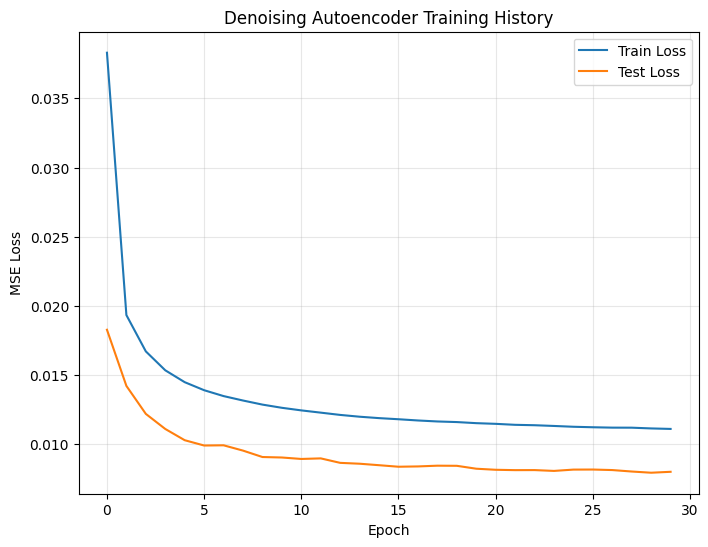

In [8]:
# Plot training history
plot_training_history(history)

Noise level 0.1: Test Loss = 0.0064
Noise level 0.2: Test Loss = 0.0067
Noise level 0.3: Test Loss = 0.0080
Noise level 0.4: Test Loss = 0.0103
Noise level 0.5: Test Loss = 0.0141
Noise level 0.6: Test Loss = 0.0191


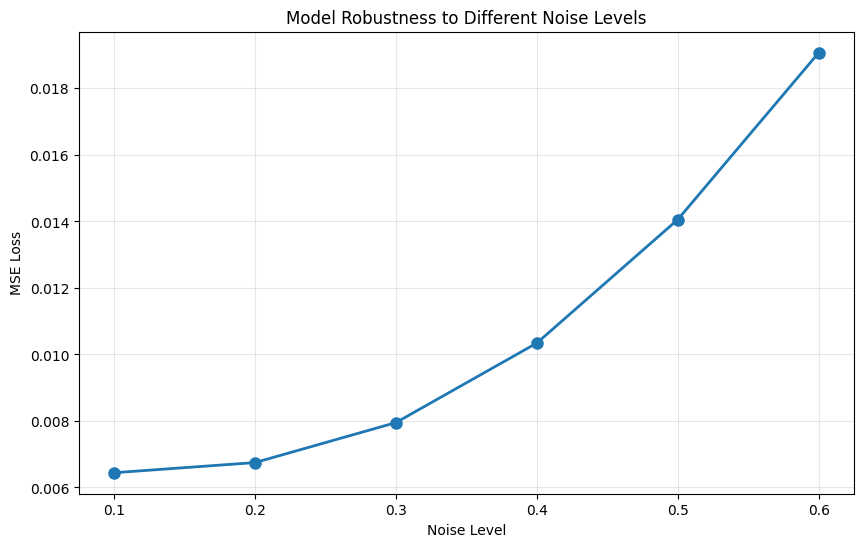

In [9]:
# Test model robustness
robustness_results = test_robustness(model, test_loader, device)
plot_robustness_results(robustness_results)

In [10]:
# Visualize some reconstructions
# Get a batch of test data
dataiter = iter(DataLoader(test_dataset, batch_size=10, shuffle=True))
images, _ = next(dataiter)
images = images.view(-1, 784).to(device)

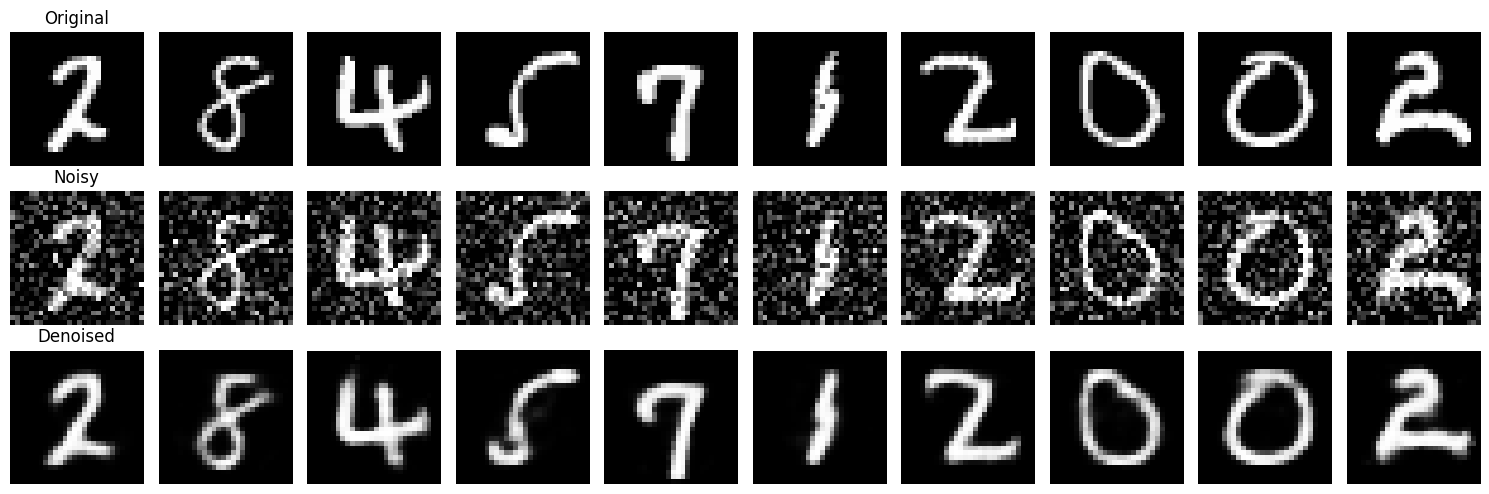

In [11]:
# Add noise
noisy_images = model.add_noise(images, noise_factor=0.3)
# Reconstruct
with torch.no_grad():
    reconstructed = model(noisy_images)

# Plot
plot_reconstruction_examples(
    images.cpu(),
    noisy_images.cpu(),
    reconstructed.cpu()
)